[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

## Setup

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

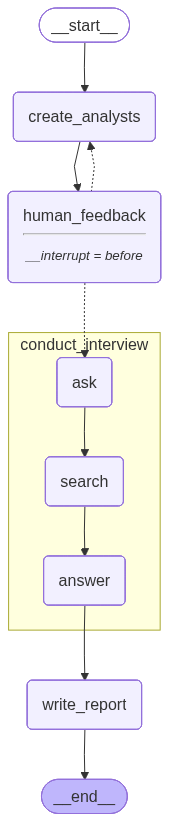

In [2]:
import operator
import json
from typing import List, Annotated, TypedDict
from pydantic import BaseModel, Field
from IPython.display import Image, display, Markdown

# LangChain & LangGraph
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Send
from langchain_ollama import ChatOllama
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, get_buffer_string
from langchain_tavily import TavilySearch

# 1. INITIALIZE OLLAMA QWEN 8B
# Ensure you have run 'ollama pull qwen2.5:8b'
llm = ChatOllama(model="qwen3:8b", temperature=0, format="json")
search_tool = TavilySearch(max_results=2)

# 2. DATA MODELS
class Analyst(BaseModel):
    affiliation: str
    name: str
    role: str
    description: str
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}"

class Perspectives(BaseModel):
    analysts: List[Analyst]

class SearchQuery(BaseModel):
    query: str

class InterviewState(MessagesState):
    analyst: Analyst
    context: Annotated[list, operator.add]
    sections: list

class OverallState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]
    sections: Annotated[list, operator.add]
    final_report: str

# 3. INTERVIEW SUB-GRAPH NODES
def ask_question(state: InterviewState):
    analyst = state["analyst"]
    sys_msg = f"You are {analyst.name}. Ask a specific research question about the topic."
    return {"messages": [llm.invoke([SystemMessage(content=sys_msg)] + state["messages"])]}

def search_node(state: InterviewState):
    structured_llm = llm.with_structured_output(SearchQuery)
    res = structured_llm.invoke([SystemMessage(content="Generate a search query JSON based on the last question.")] + state["messages"])
    search_res = search_tool.invoke(res.query)
    content = "\n\n".join([f"Source: {r['url']}\nContent: {r['content']}" for r in search_res.get('results', [])])
    return {"context": [content]}

def answer_node(state: InterviewState):
    context_str = "\n".join(state["context"])
    sys_msg = f"Answer using ONLY this context: {context_str}\nCite sources as [1], [2]."
    res = llm.invoke([SystemMessage(content=sys_msg)] + state["messages"])
    res.name = "expert"
    return {"messages": [res]}

# 4. PARENT GRAPH NODES
def create_analysts(state: OverallState):
    prompt = f"Create a team of {state['max_analysts']} analysts for: {state['topic']}. Return JSON."
    res = llm.with_structured_output(Perspectives).invoke([SystemMessage(content=prompt)])
    return {"analysts": res.analysts, "human_analyst_feedback": None}

def initiate_interviews(state: OverallState):
    return [Send("conduct_interview", {"analyst": a, "messages": [HumanMessage(content=f"Research {state['topic']}")]}) for a in state["analysts"]]

def write_report(state: OverallState):
    sections_text = "\n\n".join(state["sections"])
    res = llm.invoke(f"Synthesize this into a professional Markdown report:\n\n{sections_text}")
    return {"final_report": res.content}

# 5. CONSTRUCT FULL GRAPH
itv_builder = StateGraph(InterviewState)
itv_builder.add_node("ask", ask_question); itv_builder.add_node("search", search_node)
itv_builder.add_node("answer", answer_node)
itv_builder.add_edge(START, "ask"); itv_builder.add_edge("ask", "search")
itv_builder.add_edge("search", "answer"); itv_builder.add_edge("answer", END)
interview_graph = itv_builder.compile()

builder = StateGraph(OverallState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", lambda state: None)
builder.add_node("conduct_interview", interview_graph)
builder.add_node("write_report", write_report)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", lambda s: "conduct_interview" if not s.get('human_analyst_feedback') or s.get('human_analyst_feedback') == "OK" else "create_analysts", {"conduct_interview": "conduct_interview", "create_analysts": "create_analysts"})
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("write_report", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory, interrupt_before=["human_feedback"])
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# INITIAL INPUT
config = {"configurable": {"thread_id": "Harris_Report_001"}}
initial_input = {
    "topic": "The benefits of adopting LangGraph as an agent framework",
    "max_analysts": 3
}

for event in graph.stream(initial_input, config, stream_mode="values"):
    if "analysts" in event:
        for a in event['analysts']:
            print(f"Name: {a.name} | Role: {a.role}\nDescription: {a.description}\n{'-'*50}")

print("\n[PAUSED] If you like these analysts, run Cell 3 with feedback='OK'.")

In [ ]:
feedback = "OK" # Or change to: "Add an analyst focused on cost-efficiency"

graph.update_state(config, {"human_analyst_feedback": feedback}, as_node="human_feedback")

print("Processing parallel interviews and compiling report (this may take 1-2 minutes on i5)...")
for event in graph.stream(None, config, stream_mode="updates"):
    print(f"-- Node: {list(event.keys())[0]} completed --")

# Display Results
final_state = graph.get_state(config)
report = final_state.values.get('final_report')
display(Markdown(report))